In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


In [2]:
directory = "/content/Medical mask/Medical mask/Medical mask/annotations"
image_directory = "/content/Medical mask/Medical mask/Medical mask/images"
df = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/submission.csv")

In [19]:
cvNet = cv2.dnn.readNetFromCaffe('/content/deploy.prototxt', '/content/weights.caffemodel')
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [4]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'Annotations': [{'Attributes': {},
   'BoundingBox': [216, 171, 298, 267],
   'Confidence': 1,
   'ID': 760042762099771264,
   'classname': 'face_no_mask',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [435, 181, 483, 241],
   'Confidence': 1,
   'ID': 399284903257621248,
   'classname': 'face_no_mask',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [723, 172, 793, 253],
   'Confidence': 1,
   'ID': 80543839202656512,
   'classname': 'face_no_mask',
   'isProtected': False}],
 'FileName': '6287.jpg',
 'NumOfAnno': 3}

In [5]:
df = pd.read_csv("train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


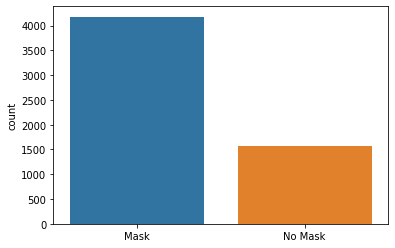

In [65]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [66]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [67]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)

datagen.fit(xtrain)

history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


143/143 [==============================] - 24s 154ms/step - loss: 0.4495 - accuracy: 0.8329 - val_loss: 0.2260 - val_accuracy: 0.9270
Epoch 2/50
143/143 [==============================] - 20s 142ms/step - loss: 0.2865 - accuracy: 0.8831 - val_loss: 0.2037 - val_accuracy: 0.9200
Epoch 3/50
143/143 [==============================] - 20s 142ms/step - loss: 0.2739 - accuracy: 0.8850 - val_loss: 0.2195 - val_accuracy: 0.9183
Epoch 4/50
143/143 [==============================] - 20s 141ms/step - loss: 0.2650 - accuracy: 0.8925 - val_loss: 0.1865 - val_accuracy: 0.9357
Epoch 5/50
143/143 [==============================] - 20s 142ms/step - loss: 0.2372 - accuracy: 0.9028 - val_loss: 0.1854 - val_accuracy: 0.9400
Epoch 6/50
143/143 [==============================] - 21s 143ms/step - loss: 0.2423 - accuracy: 0.8988 - val_loss: 0.1889 - val_accuracy: 0.9209
Epoch 7/50
143/143 [==============================] - 20s 141ms/step - loss: 0.2498 - accuracy: 0.9008 - val_loss: 0.1715 - val_accuracy: 0.9

0